# 1. Imports

In [7]:
%pip install torch numpy matplotlib pandas seaborn scikit-learn tqdm transformers optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import string
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    RobertaConfig,
    get_scheduler
)
import optuna
import json

Matplotlib is building the font cache; this may take a moment.
2025-03-04 18:07:50.670153: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 18:08:14.220515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 18:08:35.229716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [41]:
# Set reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# 2. Data Preprocessing

In [42]:
def load_and_preprocess_data():
    df = pd.read_csv('best_all_it_jobs.csv')
    columns_to_keep = ['review_text', 'sentiment']
    df = df[columns_to_keep].dropna(subset=['review_text'])

    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
    df['label'] = df['sentiment'].map(label_map)

    df_sampled = (df.groupby("sentiment")
                  .sample(n=25000, random_state=SEED, replace=True)
                  .reset_index(drop=True))

    print("=== Sample reviews (raw) ===")
    print(df_sampled['review_text'].head(3).to_list())

    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df_sampled['cleaned_review'] = df_sampled['review_text'].apply(clean_text)
    print("\n=== Sample reviews (cleaned) ===")
    print(df_sampled['cleaned_review'].head(3).to_list())
    return df_sampled

df_sampled = load_and_preprocess_data()

=== Sample reviews (raw) ===
['Bond sucks everything Depends on your project\r\nGrowth for freshers Axway project has shifts\r\nTechnologies for freshers are decided randomly and not on merit', "Good Salary with very poor management Good Teach People Good Lunch Good Building Bad Management So much additional deduction from salary Too far office Salary doesn't get in time Poor Hierarchy", "One of the worst jobs I've ever had. Miserable workplace - Work from home occasionally\r\n- Paid education - They hire from within, but only the most incompetent people\r\n- Management is severely disconnected from employees\r\n- Management has no clue about what employees do\r\n- Marketing managers don't seem to know anything about marketing!\r\n- Graphic design teams and writers are treated very very poorly by people who are not fit for their jobs\r\n- Sort of like working in the tobacco industry - they pretend there's nothing wrong with the status quo"]

=== Sample reviews (cleaned) ===
['bond suck

# 3. Tokenization

In [43]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_data(df, max_length=256):
    return tokenizer(
        text=df['cleaned_review'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False
    )

In [44]:
tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

# 4. Data Splitting

In [45]:
def stratified_split(inputs, masks, labels, test_size=0.3):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=SEED)
    train_idx, temp_idx = next(sss.split(inputs, labels))
    return (inputs[train_idx], masks[train_idx], labels[train_idx]), \
           (inputs[temp_idx], masks[temp_idx], labels[temp_idx])

In [46]:
(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids, attention_mask, labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks, temp_labels, test_size=0.5)

# 5. DataLoader

In [47]:
def create_dataloader(inputs, masks, labels, batch_size, shuffle=False):
    return DataLoader(
        TensorDataset(inputs, masks, labels),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )

# 6. Training Function

In [50]:
def train(model, train_loader, optimizer, scheduler, params, device):
    model.train()
    total_loss = 0
    scaler = torch.cuda.amp.GradScaler()
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs, attention_mask=masks, labels=lbls)
            loss = outputs.loss / params['grad_accum_steps']
        scaler.scale(loss).backward()
        if (step + 1) % params['grad_accum_steps'] == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), params['grad_clip'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        total_loss += loss.item() * params['grad_accum_steps']
    return total_loss / len(train_loader)

# 7. Evaluation Function

In [48]:
def evaluate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in val_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    return acc, f1, precision, recall

In [49]:
def evaluate_with_metrics(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in test_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return cm, acc, f1, precision, recall

# 8. Hyperparameter Tuning with Optuna

In [51]:
USE_OPTUNA = False

default_params = {
    'lr': 3e-5,
    'weight_decay': 1e-5,
    'num_epochs': 5,
    'hidden_dropout': 0.3,
    'attention_dropout': 0.3,
    'batch_size': 32,
    'grad_clip': 1.0,
    'grad_accum_steps': 1
}

In [52]:
def run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device):
    from transformers import RobertaConfig, RobertaForSequenceClassification

    def objective(trial):
        params = {
            'lr': trial.suggest_float('lr', 1e-5, 3e-5, log=True),
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True),
            'num_epochs': trial.suggest_int('num_epochs', 4, 8),
            'hidden_dropout': trial.suggest_float('hidden_dropout', 0.1, 0.3),
            'attention_dropout': trial.suggest_float('attention_dropout', 0.1, 0.3),
            'batch_size': trial.suggest_categorical('batch_size', [16, 32]),
            'grad_clip': trial.suggest_float('grad_clip', 0.5, 1.0),
            'grad_accum_steps': trial.suggest_int('grad_accum_steps', 1, 2)
        }

        print(f"\n--- Starting trial with params: {params} ---")
        train_loader = create_dataloader(train_inputs, train_masks, train_labels, params['batch_size'], shuffle=True)
        val_loader = create_dataloader(val_inputs, val_masks, val_labels, params['batch_size'])

        config = RobertaConfig.from_pretrained(
            'roberta-base',
            num_labels=3,
            hidden_dropout_prob=params['hidden_dropout'],
            attention_probs_dropout_prob=params['attention_dropout']
        )
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        total_steps = (len(train_loader) // params['grad_accum_steps']) * params['num_epochs']
        scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

        best_f1 = 0
        for epoch in range(params['num_epochs']):
            train(model, train_loader, optimizer, scheduler, params, device)
            acc, f1, _, _ = evaluate(model, val_loader, device)
            print(f"Trial {trial.number}, Epoch {epoch+1}/{params['num_epochs']} - Val Acc: {acc:.4f}, Val F1: {f1:.4f}")
            trial.report(f1, epoch)
            if trial.should_prune():
                print("Trial pruned!")
                raise optuna.TrialPruned()
            best_f1 = max(best_f1, f1)

        print(f"Trial {trial.number} finished with best validation F1: {best_f1:.4f}")
        return best_f1

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
    )
    study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

    best_params = study.best_params.copy()
    print("\nBest Hyperparameters Found:")
    print(best_params)
    return best_params


# 9. Final Training with Best Parameters

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

df_sampled = load_and_preprocess_data()
tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids,
                                                                                                     attention_mask,
                                                                                                     labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks,
                                                                                               temp_labels,
                                                                                               test_size=0.5)

if USE_OPTUNA:
    best_params = run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device)
    with open("best_params_roberta.json", "w") as f:
        json.dump(best_params, f)
    print("Best hyperparameters saved to best_params_bert.json.")
else:
    try:
        with open("best_params_roberta.json", "r") as f:
            best_params = json.load(f)
        print("Loaded hyperparameters from best_params_bert.json:")
        print(best_params)
    except FileNotFoundError:
        best_params = default_params
        print("\nUsing default hyperparameters:")
        print(best_params)

Using device: cuda
=== Sample reviews (raw) ===
['Bond sucks everything Depends on your project\r\nGrowth for freshers Axway project has shifts\r\nTechnologies for freshers are decided randomly and not on merit', "Good Salary with very poor management Good Teach People Good Lunch Good Building Bad Management So much additional deduction from salary Too far office Salary doesn't get in time Poor Hierarchy", "One of the worst jobs I've ever had. Miserable workplace - Work from home occasionally\r\n- Paid education - They hire from within, but only the most incompetent people\r\n- Management is severely disconnected from employees\r\n- Management has no clue about what employees do\r\n- Marketing managers don't seem to know anything about marketing!\r\n- Graphic design teams and writers are treated very very poorly by people who are not fit for their jobs\r\n- Sort of like working in the tobacco industry - they pretend there's nothing wrong with the status quo"]

=== Sample reviews (clean

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded hyperparameters from best_params_bert.json:
{'lr': 1.3974545876676635e-05, 'weight_decay': 1.5679933916723006e-06, 'num_epochs': 7, 'hidden_dropout': 0.18803049874792027, 'attention_dropout': 0.12440764696895577, 'batch_size': 16, 'grad_clip': 0.954660201039391, 'grad_accum_steps': 1}


In [ ]:
train_loader = create_dataloader(train_inputs, train_masks, train_labels, best_params['batch_size'], shuffle=True)
val_loader = create_dataloader(val_inputs, val_masks, val_labels, best_params['batch_size'])
test_loader = create_dataloader(test_inputs, test_masks, test_labels, best_params['batch_size'])

from transformers import RobertaConfig, RobertaForSequenceClassification

config = RobertaConfig.from_pretrained(
    'roberta-base',
    num_labels=3,
    hidden_dropout_prob=best_params['hidden_dropout'],
    attention_probs_dropout_prob=best_params['attention_dropout']
)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config).to(device)

optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
total_steps = (len(train_loader) // best_params['grad_accum_steps']) * best_params['num_epochs']
scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

In [54]:
train_losses = []
val_accuracies = []
val_f1_scores = []
best_val_f1 = 0
patience_counter = 0

for epoch in range(best_params['num_epochs']):
    train_loss = train(model, train_loader, optimizer, scheduler, best_params, device)
    train_losses.append(train_loss)

    acc, f1, _, _ = evaluate(model, val_loader, device)
    val_accuracies.append(acc)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Acc = {acc:.4f}, Val F1 = {f1:.4f}")

    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_roberta_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 3:
            print("Early stopping triggered")
            break

Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.7063, Val Acc = 0.7844, Val F1 = 0.7837


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.5021, Val Acc = 0.8260, Val F1 = 0.8260


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.4294, Val Acc = 0.8427, Val F1 = 0.8421


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.3758, Val Acc = 0.8375, Val F1 = 0.8374


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.3360, Val Acc = 0.8547, Val F1 = 0.8547


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.3048, Val Acc = 0.8614, Val F1 = 0.8615


Training:   0%|          | 0/3282 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.2795, Val Acc = 0.8627, Val F1 = 0.8627


# 10. Plot Training Graphs

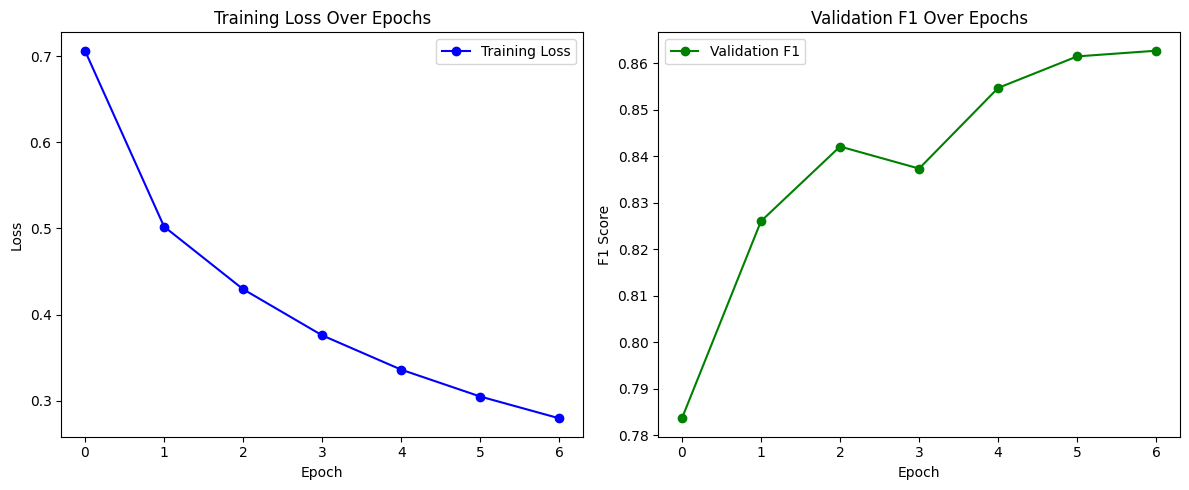

In [55]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1', color='green', marker='o')
plt.title('Validation F1 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# 11. Final Evaluation

Test Accuracy: 0.8600
Test Precision: 0.8602
Test Recall: 0.8600
Test F1 Score: 0.8598


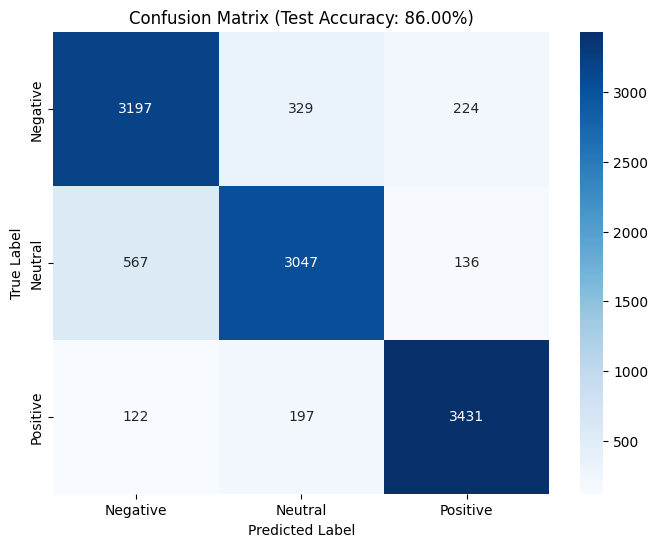

In [56]:
model.load_state_dict(torch.load('best_roberta_model.pth'))
cm, test_acc, test_f1, test_precision, test_recall = evaluate_with_metrics(model, test_loader, device)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix (Test Accuracy: {test_acc:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()